<a href="https://colab.research.google.com/github/sidneyFdev/Dio-me_Transfer_Learning_Class_Project_01/blob/main/ML_Transfer_Learning_em_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio DIO.ME - Transfer Learning em Python
## Passos de preparação

##Download das imagens para o projeto.

Antes de iniciar o codigo Python, devemos fazer o download das imagens. No meu exemplo estou usando o repositório da Microsoft 'Cats and Dogs', que possui mais de 10000 imagens para cada um, extraindo o arquivo ZIP e removendo-o do projeto em seguida.

Logo abaixo, também faremos download de poucas imagens para diretórios de testes para verificar a precisão do aprendizado.

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!echo 'Extraindo imagens do arquivo ZIP...'
!unzip -q kagglecatsanddogs_5340.zip
!echo 'Removendo arquivo ZIP.'
!rm -rf kagglecatsanddogs_5340.zip

--2025-02-16 17:34:18--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.213.150.23, 2600:1408:c400:168a::317f, 2600:1408:c400:1680::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.213.150.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   113MB/s    in 9.1s    

2025-02-16 17:34:27 (86.6 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]

Extraindo imagens do arquivo ZIP...
Removendo arquivo ZIP.


### Importando as bibliotecas

Neste passo, estaremos importando as bibliotecas necessárias para utilização neste projeto.

Uma observação sobre este passo comparado ao exemplo mostrado durante as aulas é que do keras, devemos importar as ferramentas como keras.api, caso contrário, não irá funcionar.

In [ ]:
%matplotlib inline
import random
import numpy as np
import keras
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.api.applications.imagenet_utils import preprocess_input
from keras.api.utils import load_img, img_to_array
from keras.api.models import Sequential, Model
from keras.api.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D

###Definindo variaveis que serão usadas durante o projeto

Aqui estamos definindo quais categorias iremos analisar (neste exemplo, gatos e cachorros), qual pasta estão as imagens para treinamento, validação e teste, além dos números de divisão entre o treinamento de acordo com o total de imagens.

In [ ]:
data_folder = 'PetImages'
train_split, val_split = 0.7, 0.15
categories = [x[0] for x in os.walk(data_folder) if x[0]][1:]

### Diminuindo quantidade de dados processados

Durante a realização dos testes, não consegui finalizar o treinamento com todas as imagens, pois os 25000 imagens em processamento excediam a quantidade de RAM utilizada no Google Colab.

Há outras soluções para resolver este problema, porém como este projeto é somente para estudo, removi 90% das imagens para manter o processamento mais leve.

In [ ]:
for category in os.listdir(data_folder ):
    all_images = []
    category_path = os.path.join(data_folder , category)
    if os.path.isdir(category_path):
        all_images.extend([os.path.join(category_path, f) for f in os.listdir(category_path)
                           if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']])
    print(f"Total de imagens em {category}: {len(all_images)}")
    random.shuffle(all_images)
    removable_images = all_images[len(all_images) // 10:]
    for img_path in removable_images:
        os.remove(img_path)
    print(f'Total de imagens en {category} após a diminuição de 1/10: {len(os.listdir(category_path))}')

Total de imagens em Cat: 12500
Total de imagens en Cat após a diminuição de 1/10: 1251
Total de imagens em Dog: 12500
Total de imagens en Dog após a diminuição de 1/10: 1251


## Inicio do processamento das imagens
### Função base

Dando inicio a leitura do dataset, neste passo definimos a função que lerá cada uma das imagens através do caminoh da mesma em sistema.

In [ ]:
def load_image(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

### Armazenando todas as imagens na variável DATA.

Através do código a seguir, iniciamos dois loops para checar todas as imagens no diretório de imagens, sendo uma para cada categória e outra para cada imagem dentro da categoria.

In [ ]:
data = []
for c, category in enumerate(categories):
  images = [os.path.join(dp, f) for dp, dn, filenames
            in os.walk(category) for f in filenames
            if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]
  for img_path in images:
    try:
      img, x = load_image(img_path)
      data.append({'x':np.array(x[0]), 'y':c})
    except Exception as e:
      print(f"Não foi possível carregar a imagem {img_path}")
      print(e)
num_classes = len(categories)
random.shuffle(data)

### Delimitando quantas serão as imagens de treinamento, validação e teste automatizado

Nestas 4 etapas de codigo, definiremos quais arquivos serão utilizados para cada etapa do processo, além de construir a base para nossa rede neural que será capaz de identificar e classificar os itens do dataset.

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

In [ ]:
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(375, 2)


In [ ]:
model = Sequential()
print("Dimensções de entrada: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

## Inicio do treinamento
### Treinando o modelo

A partir daqui, iremos treinar nosso modelo utilizando 100 epocas que provavelmente serão o suficiente para este exepmlo, definidas no código abaixo com o otimizador ADAM.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 135s 9s/step - accuracy: 0.4870 - loss: 0.7061 - val_accuracy: 0.4933 - val_loss: 0.6894
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 139s 10s/step - accuracy: 0.4998 - loss: 0.6808 - val_accuracy: 0.5973 - val_loss: 0.6737
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 126s 9s/step - accuracy: 0.5969 - loss: 0.6540 - val_accuracy: 0.5787 - val_loss: 0.6595
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.6371 - loss: 0.6350 - val_accuracy: 0.6027 - val_loss: 0.6439
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 139s 9s/step - accuracy: 0.6244 - loss: 0.6179 - val_accuracy: 0.6027 - val_loss: 0.6381
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 126s 9s/step - accuracy: 0.6372 - loss: 0.6195 - val_accuracy: 0.6347 - val_loss: 0.6425
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 9s/step - accuracy: 0.6526 - loss: 0.6083 - val_accuracy: 0.6853 - val_loss: 0.5922
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - accuracy: 0.7156 - loss: 0.5588 - val_accuracy: 0.7120 - 

### Visualização da taxa de perdas e acertos

Aqui, podemos ter um modelo visual da taxa de sucesso do nosso treinamento.


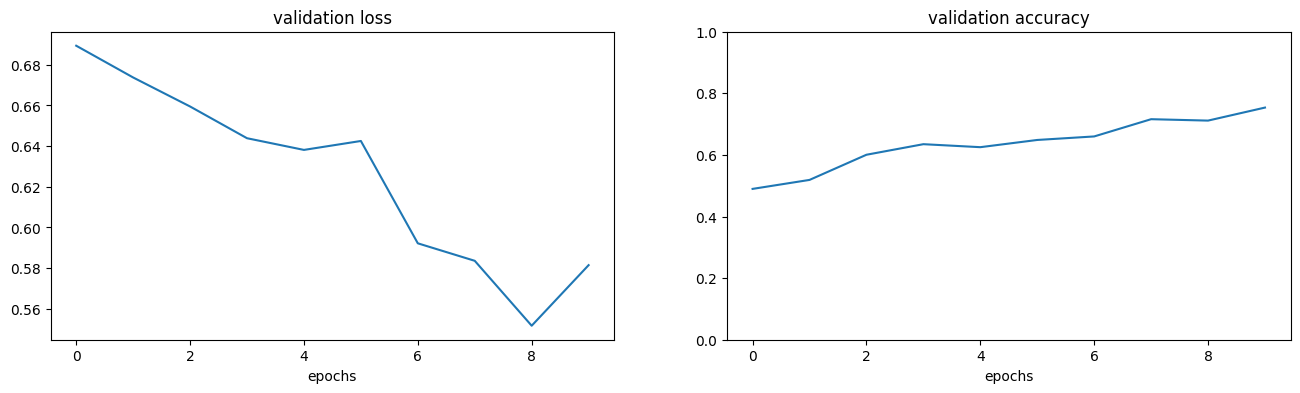

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")
ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Perdas em teste:', loss)
print('Acertos em teste:', accuracy)

Perdas em teste: 0.5779708623886108
Acertos em teste: 0.7226666808128357
